In [1]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai.imports import *

In [2]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1650


In [3]:
################################DATASET####################

In [4]:
#Create a Path with the origin folder of the dataset
origin = Path("C:/Development/meteor_detector/dataset/v7_adjusted/dataset/")

In [5]:
#Create a DataFrame scanning the folder and searching for the subfolders test_set and training_set. Inside this folders there
#should be a meteor and no-meteor subfolders
rows_values = []
for dataset in ["test_set", "training_set"]:
    for meteor in ["meteor", "no-meteor"]:
        for fn in (origin/f"{dataset}/{meteor}").glob("*/"):
            rows_values += [(str(fn)[len(str(origin)):], dataset, meteor)]
df = pd.DataFrame(rows_values, columns=["fn", "dataset", "meteor"])
df

,fn,dataset,meteor
0,\test_set\meteor\image-20210219194325.jpg,test_set,meteor
1,\test_set\meteor\image-20210219195726.jpg,test_set,meteor
2,\test_set\meteor\image-20210220000355.jpg,test_set,meteor
3,\test_set\meteor\image-20210220061647.jpg,test_set,meteor
4,\test_set\meteor\image-20210220063819.jpg,test_set,meteor
...,...,...,...
57165,\training_set\no-meteor\image-20210413064838.jpg,training_set,no-meteor
57166,\training_set\no-meteor\image-20210413064908.jpg,training_set,no-meteor
57167,\training_set\no-meteor\image-20210413064938.jpg,training_set,no-meteor
57168,\training_set\no-meteor\image-20210413065008.jpg,training_set,no-meteor


In [6]:
#Grouping the dataset by train and test and by class
df.groupby(["dataset","meteor"]).size()

dataset       meteor   
test_set      meteor         300
              no-meteor     5008
training_set  meteor        1567
              no-meteor    50295
dtype: int64

In [7]:
#Save the dataset to CSV
df.to_csv("C:/Development/meteor_detector/dataset/index.csv", index=False)

In [8]:
#Checking the training_set
df[df.dataset=="training_set"]

,fn,dataset,meteor
5308,\training_set\meteor\image-20210219194125.jpg,training_set,meteor
5309,\training_set\meteor\image-20210219194155.jpg,training_set,meteor
5310,\training_set\meteor\image-20210219194225.jpg,training_set,meteor
5311,\training_set\meteor\image-20210219194255.jpg,training_set,meteor
5312,\training_set\meteor\image-20210219195756.jpg,training_set,meteor
...,...,...,...
57165,\training_set\no-meteor\image-20210413064838.jpg,training_set,no-meteor
57166,\training_set\no-meteor\image-20210413064908.jpg,training_set,no-meteor
57167,\training_set\no-meteor\image-20210413064938.jpg,training_set,no-meteor
57168,\training_set\no-meteor\image-20210413065008.jpg,training_set,no-meteor


In [9]:
#Dataset Balacing. Sampling the class no-meteor
df_no_meteor_train = df[(df["meteor"]=="no-meteor") & (df["dataset"]=="training_set")].sample(n=1567) 
df_no_meteor_test  = df[(df["meteor"]=="no-meteor") & (df["dataset"]=="test_set")].sample(n=1000)
df_meteor_train    = df[(df["meteor"]=="meteor")    & (df["dataset"]=="training_set")]
df_meteor_test     = df[(df["meteor"]=="meteor")    & (df["dataset"]=="test_set")]

df=pd.concat([df_no_meteor_train,df_no_meteor_test,df_meteor_train,df_meteor_test])

In [10]:
#Checking the balanced dataset
df.groupby(["dataset","meteor"]).size()

dataset       meteor   
test_set      meteor        300
              no-meteor    1000
training_set  meteor       1567
              no-meteor    1567
dtype: int64

In [25]:
#Create an ImageLoader, applying some transformations to generate Data Augmentation
#The ImageLoader gets the images from the training_set
dls = ImageDataLoaders.from_df(df[df["dataset"]!="test_set"],
                               folder=origin ,
                               bs=32, 
                               batch_tfms=aug_transforms(max_rotate=180,max_warp=0,max_zoom=0),
                               item_tfms=[Resize(224)],
                               fn_col=0, 
                               label_col=2, 
                               shuffle_train=True,
                               drop_last=True,
                               valid_pct=0.2,
                               num_workers=0)

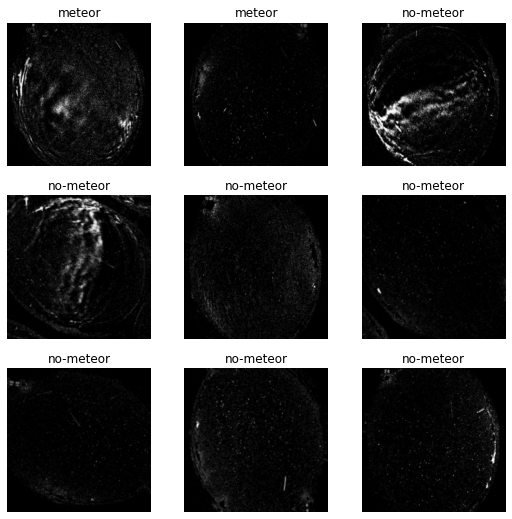

In [26]:
#Show a batch of images from the ImageLoader
dls.show_batch()

In [27]:
#Create e learner using the ImageLoader and a pre-trained resnet34
learn = cnn_learner(dls, resnet34, 
                metrics=[error_rate, accuracy, Precision(average='macro'), F1Score(average='macro')],
                    cbs=[EarlyStoppingCallback(patience=25), ShowGraphCallback()]
                   )

In [28]:
#Checking the transformations
print(learn.dls.train.after_batch)
print(learn.dls.valid.after_batch)

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


In [29]:
#Checking the loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=3.981071756697929e-07)

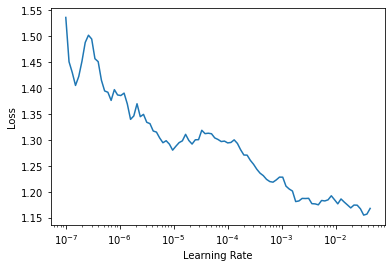

In [30]:
#Geting a grph of the loss value by different values of learning rate. Will help identify the best learning rate to train
learn.lr_find(end_lr=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,f1_score,time
0,1.027255,0.698053,0.301917,0.698083,0.699920,0.698076,00:37


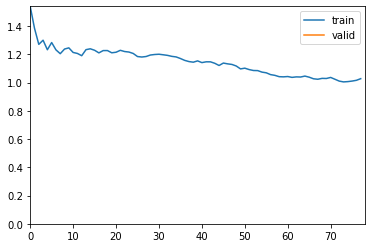

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,f1_score,time
0,0.840081,0.586470,0.261981,0.738019,0.745707,0.737695,00:51
1,0.769951,0.500975,0.225240,0.774760,0.774007,0.774054,00:58
2,0.699251,0.455661,0.218850,0.781150,0.787581,0.777234,00:59
3,0.684627,0.433616,0.201278,0.798722,0.806963,0.794850,00:58
4,0.611655,0.395797,0.174121,0.825879,0.831048,0.823478,00:56
5,0.558520,0.423893,0.170927,0.829073,0.850326,0.823729,00:59
6,0.536031,0.367601,0.172524,0.827476,0.827673,0.827363,00:55
7,0.483137,0.329209,0.151757,0.848243,0.848009,0.847589,00:59
8,0.428750,0.307306,0.132588,0.867412,0.868808,0.866455,00:54
9,0.388456,0.329323,0.130990,0.869010,0.878151,0.866835,00:57


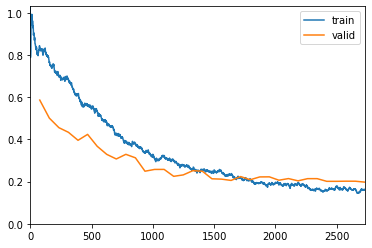

In [31]:
#Execute the Transfer Learning process with 35 epochs and a learning rate of =0,003
learn.fine_tune(35,1*1e-3)

In [33]:
#Load or Save Model
#learn.export('C:/Development/guaita/guaita/guAIta_latest_version.pkl')
#learn = load_learner('C:/Development/guaita/guaita/guAIta_latest_version.pkl')

In [32]:
#Checking the performance of the learner over the test_set
interp = ClassificationInterpretation.from_learner(learn, dl=learn.dls.test_dl(df[df["dataset"]=="test_set"], with_labels=True, bs=100))
interp.print_classification_report()

              precision    recall  f1-score   support

      meteor       0.77      0.93      0.84       300
   no-meteor       0.98      0.92      0.95      1000

    accuracy                           0.92      1300
   macro avg       0.87      0.92      0.89      1300
weighted avg       0.93      0.92      0.92      1300



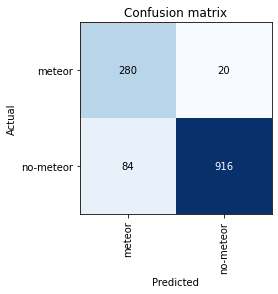

In [33]:
#Get the confusion matrix
interp.plot_confusion_matrix(figsize=(4, 4))

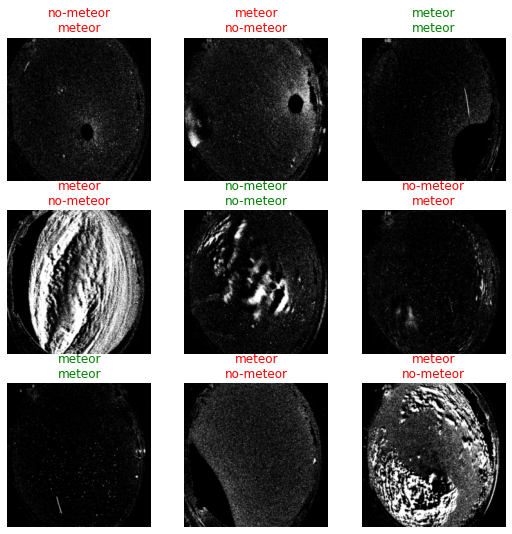

In [34]:
#show some results
learn.show_results()

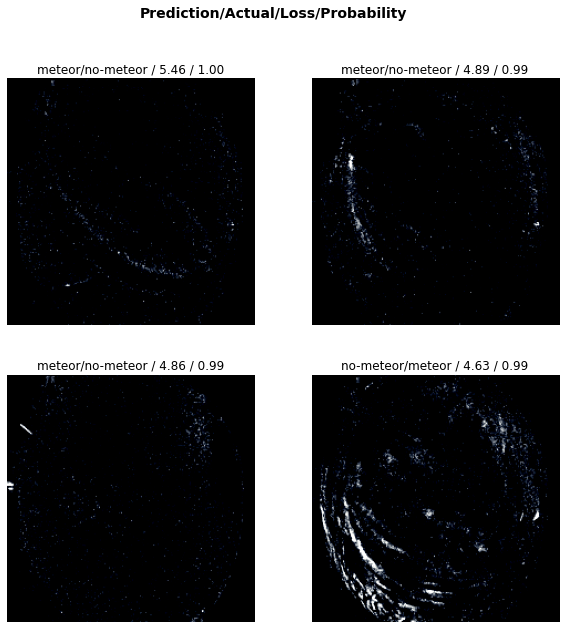

In [36]:
#Get the top losses of the learner
interp.plot_top_losses(k=4,figsize=(10,10))


In [37]:
#Get the top losses by filename, to help move files bad labeled
losses,idxs = interp.top_losses(10)
df[df["dataset"]=="test_set"].iloc[idxs]

,fn,dataset,meteor
4665,\test_set\no-meteor\image-20210505004757.jpg,test_set,no-meteor
4768,\test_set\no-meteor\image-20210505014703.jpg,test_set,no-meteor
2734,\test_set\no-meteor\image-20210423045608.jpg,test_set,no-meteor
281,\test_set\meteor\image-20210505041651.jpg,test_set,meteor
2737,\test_set\no-meteor\image-20210423045738.jpg,test_set,no-meteor
404,\test_set\no-meteor\image-20210418215042.jpg,test_set,no-meteor
4659,\test_set\no-meteor\image-20210505004457.jpg,test_set,no-meteor
5160,\test_set\no-meteor\image-20210505051428.jpg,test_set,no-meteor
3180,\test_set\no-meteor\image-20210429230003.jpg,test_set,no-meteor
4429,\test_set\no-meteor\image-20210504220144.jpg,test_set,no-meteor


In [38]:
#Model Evaluation

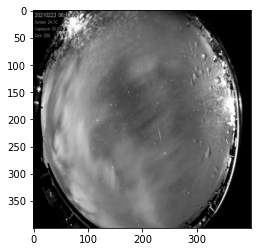

In [39]:
#Instantiate images for testing
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/tractades/positive_4.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [40]:
#Create a Hook class for Class Activation Maps evaluation
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [41]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [43]:
#For the cls=0 (meteor), we intercept the features of the last convolutional layer 
cls = 0
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [44]:
#The weights for our CAM are given by the average of our gradients across the feature map.
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


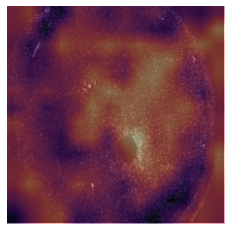

In [45]:
# Print the image adding a heatmap with the cam_map values
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [46]:
#Get the scoring and classification for the image
learn.predict(img)

('meteor', tensor(0), tensor([0.8125, 0.1875]))

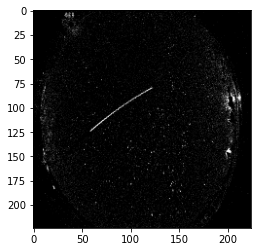

In [47]:
#Same procedure, with different images, predict them and get the heatmap
img = PILImage.create('C:/Development/meteor_detector/dataset/vDef_dia0504/test/my2.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [48]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored


In [49]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

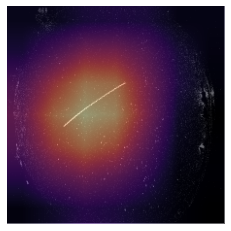

In [50]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [51]:
learn.predict(img)

('meteor', tensor(0), tensor([9.9925e-01, 7.5469e-04]))

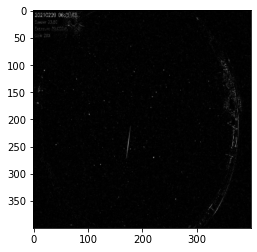

In [52]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_1.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [53]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored


In [54]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

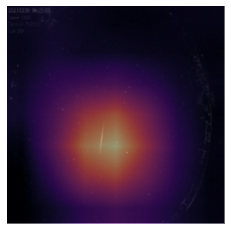

In [55]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [56]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9956, 0.0044]))

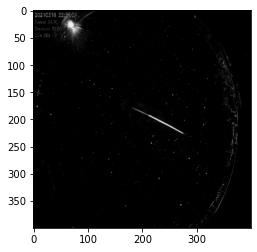

In [57]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_2.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

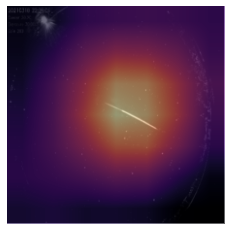

In [58]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [59]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9963, 0.0037]))

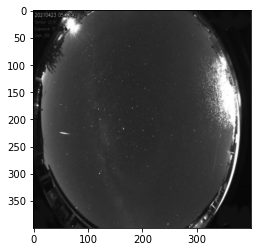

In [60]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_14.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

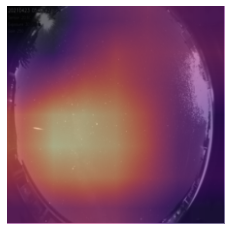

In [61]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [62]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9962, 0.0038]))

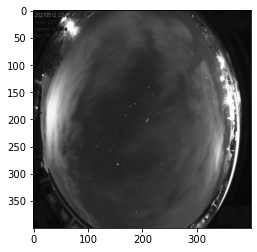

In [63]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_18.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

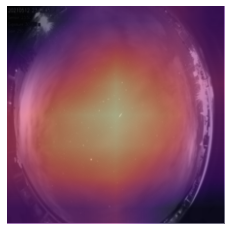

In [64]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [65]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9986, 0.0014]))

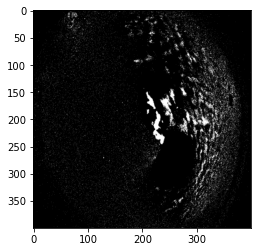

In [66]:
img = PILImage.create('C:/Development/meteor_detector/dataset/v7_adjusted/dataset/test_set/no-meteor/image-20210423001200.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [67]:
learn.predict(img)

('no-meteor', tensor(1), tensor([1.7636e-05, 9.9998e-01]))

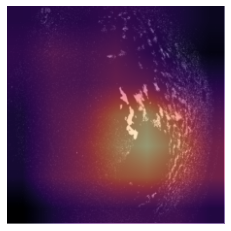

In [68]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

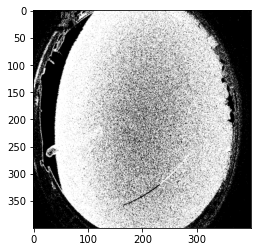

In [69]:
img = PILImage.create('C:/Development/meteor_detector/dataset/v7/dataset/test_set/meteor/image-20210321060030.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [70]:
learn.predict(img)

('meteor', tensor(0), tensor([9.9964e-01, 3.5906e-04]))

In [71]:
cls = 0
with HookBwd(learn.model[0][-1]) as hookg:
    with Hook(learn.model[0][-1]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [72]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

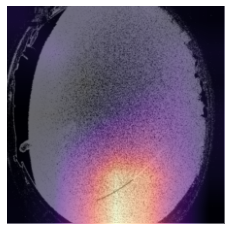

In [73]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

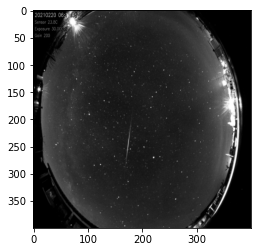

In [74]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_5.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [75]:
learn.predict(img)

('meteor', tensor(0), tensor([9.9966e-01, 3.4233e-04]))

In [76]:
cls = 0
with HookBwd(learn.model[0][-1]) as hookg:
    with Hook(learn.model[0][-1]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [77]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

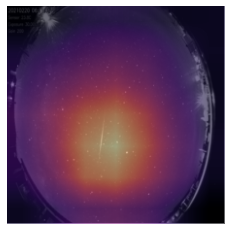

In [78]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

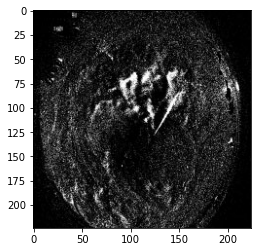

In [79]:
#Detection during pilot in Pujalt
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/pilot_detection.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [80]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9895, 0.0105]))

In [81]:
cls = 0
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [82]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

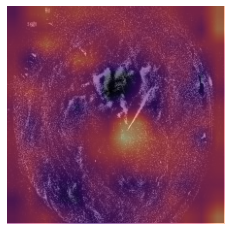

In [83]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [84]:
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  